<a href="https://colab.research.google.com/github/saiprakashgorti/Illinois-CS-441/blob/main/CS_441_HW_1_Self.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

In [2]:
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Reverse the order of the training images and labels
    x_train = x_train[::-1]
    y_train = y_train[::-1]

    # reshape 2D array image into a 1D 784 sized vectore
    x_train = np.reshape(x_train, (len(x_train), 28*28))
    x_test = np.reshape(x_test, (len(x_test), 28*28))

    # normalize the values in the images vectors
    max_value = x_train.max()
    x_train = x_train/max_value
    x_test = x_test/max_value

    return (x_train, y_train), (x_test, y_test)


In [3]:
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  if subplot_rows > 1 or subplot_cols > 1:
    # Create a grid of subplots with the specified number of rows and columns
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))

    # Loop over the images to be displayed
    for i in np.arange(len(x)):
      # Reshape the i-th image back to its original 28x28 format
      # Display the image in grayscale
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
    # Display a single image
    plt.imshow(np.reshape(x, (28,28)), cmap='gray')
    plt.axis('off')
  plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


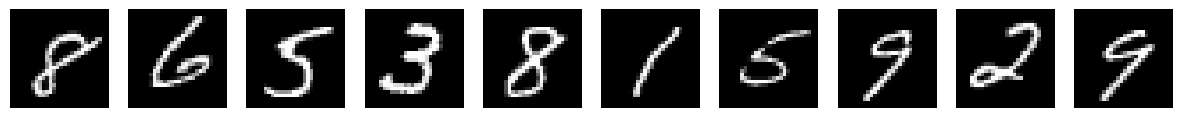

In [4]:
(x_train, y_train), (x_test, y_test) = load_mnist()
display_mnist(x_train[:10],1,10)

In [5]:
# Retrieval
def get_nearest(X_query, X):
  distances = np.linalg.norm(X - X_query, axis=1)
  return np.argmin(distances)

j = get_nearest(x_test[0], x_train)
print(j)
j = get_nearest(x_test[1], x_train)
print(j)

6156
31117


1000


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


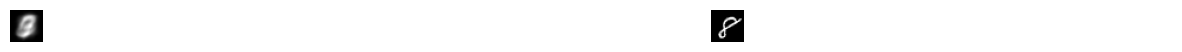

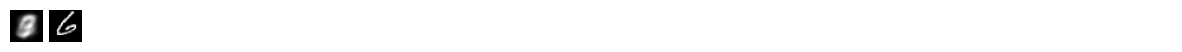

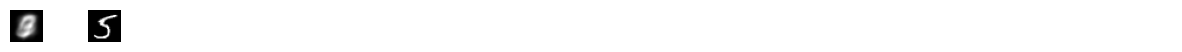

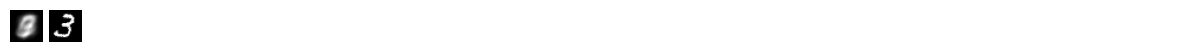

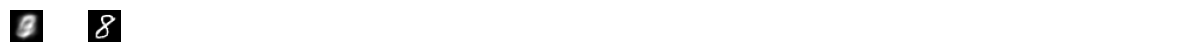

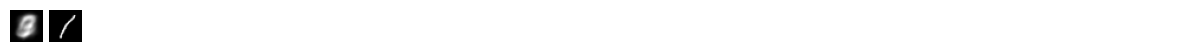

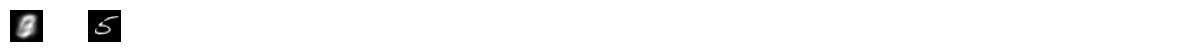

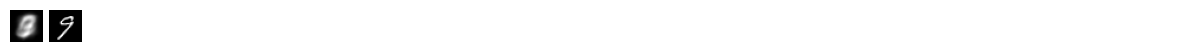

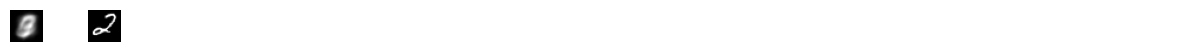

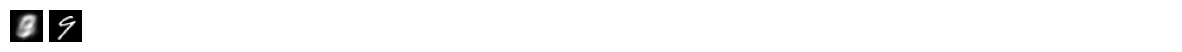

In [6]:
# K-means
def kmeans(X, K, niter=10):
  centers = X[:K].copy()
  print(len(X))
  for n in range(niter):
    idx = np.zeros(len(X))

    for i in range(len(X)):
      idx[n] = get_nearest(X[i], centers)

    for k in range(K):
      centers[k] = np.mean(X[idx == k], axis=0)

    # Display the clusters after every iteration
    display_mnist(centers, 1, K)

  return centers

K=30
centers = kmeans(x_train[:1000], K)

In [7]:
# 1-NN
def oneNN(n_test_samples, n_train_samples):
  errors = 0
  for i in range(n_test_samples):
    nearest = get_nearest(x_test[i], x_train[:n_train_samples])
    if y_train[nearest] != y_test[i]:
      errors += 1
  return errors/n_test_samples * 100
print(f"Error for 10000 samples: {oneNN(100, 1000): .1f}%")
print(f"Error for 10000 samples: {oneNN(100, 10000): .1f}%")

Error for 10000 samples:  19.0%
Error for 10000 samples:  7.0%


# Make it Fast

In [8]:
!apt install libomp-dev
!pip install faiss-cpu
import faiss
import time

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 738 kB of archives.
After this operation, 8,991 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp5-14 amd64 1:14.0.0-1ubuntu1.1 [389 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp-14-dev amd64 1:14.0.0-1ubuntu1.1 [347 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp-dev amd64 1:14.0-55~exp2 [3,074 B]
Fetched 738 kB in 0s (2,723 kB/s)
Selecting previously unselected package libomp5-14:amd64.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../libomp5-14_1%3a

In [9]:
index = faiss.IndexFlatL2(x_train.shape[1])
index.add(x_train)

In [10]:
# prompt: # retrieval
# # TO DO (check that you're using FAISS correctly)

D, I = index.search(x_test[:2], 1)
print(I)


[[ 6156]
 [31117]]


In [25]:
def kmeans_fast(X, K, niter=10):
    # Initialize centers randomly
    centers = X[:K].copy()
    rmse = []

    # FAISS index for calculating distance to all centers
    index = faiss.IndexFlatL2(X.shape[1])
    index.add(centers)

    for _ in range(niter):
        # To calculate distances to all centers
        dist, labels = index.search(X, K)

        # To assign each point to the nearest center
        labels = np.argmin(dist, axis=1)

        # To update centers
        new_centers = np.zeros_like(centers)
        for i in range(K):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centers[i] = cluster_points.mean(axis=0)
            else:
                new_centers[i] = X[np.random.choice(len(X))]
        # next i'll compute RMSE
        rmse.append(np.sqrt(((centers - new_centers) ** 2).sum() / K))

        # update the centers
        centers = new_centers

        # update FAISS index with new centers
        index.reset()
        index.add(centers)
    return centers, rmse

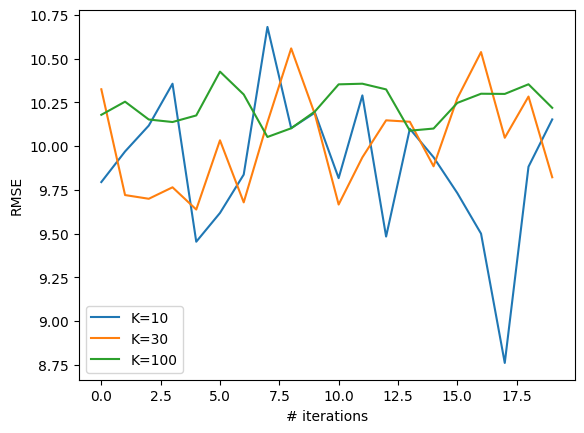

In [26]:
K=10
centers, rmse = kmeans_fast(x_train, K, niter=20)
plt.plot(np.arange(len(rmse)), rmse, label='K=10')

K=30
centers, rmse = kmeans_fast(x_train, K, niter=20)
plt.plot(np.arange(len(rmse)), rmse, label='K=30')

K=100
centers, rmse = kmeans_fast(x_train, K, niter=20)
plt.plot(np.arange(len(rmse)), rmse, label='K=100')

plt.legend(), plt.ylabel('RMSE'), plt.xlabel('# iterations')
plt.show()

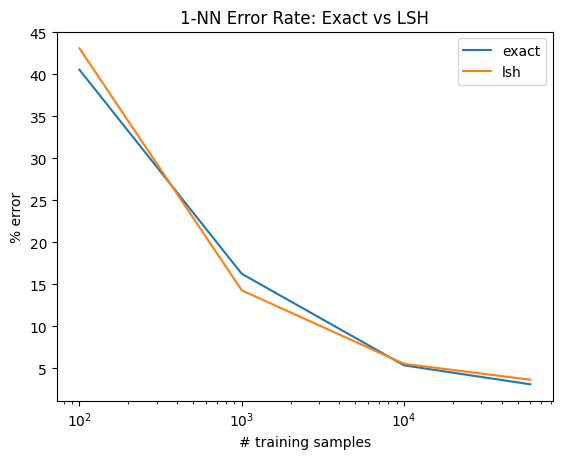

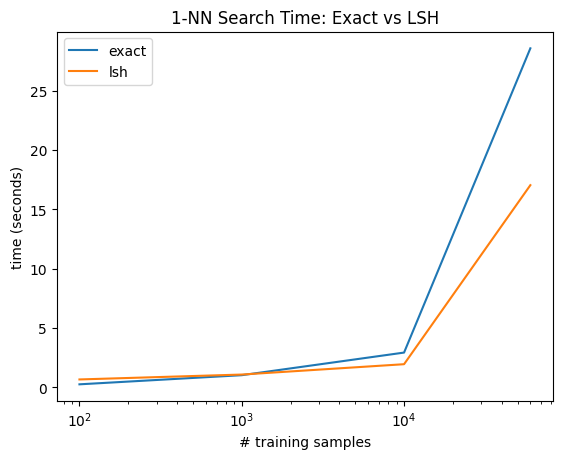

In [45]:
dim = x_train.shape[1]

nsample = [100, 1000, 10000, 60000]
acc_exact = []
acc_lsh = []
timing_exact = []
timing_lsh = []

for s in nsample:
    train_subset = x_train[:s]

    # Exact search
    index_exact = faiss.IndexFlatL2(dim)
    index_exact.add(train_subset)

    start_time = time.time()
    D_exact, I_exact = index_exact.search(x_test, 1)
    timing_exact.append(time.time() - start_time)

    pred_exact = y_train[I_exact.flatten()]
    acc_exact.append(np.mean(pred_exact == y_test))

    # LSH search
    index_lsh = faiss.IndexLSH(dim, dim)
    index_lsh.add(train_subset)

    start_time = time.time()
    D_lsh, I_lsh = index_lsh.search(x_test, 1)
    timing_lsh.append(time.time() - start_time)

    pred_lsh = y_train[I_lsh.flatten()]
    acc_lsh.append(np.mean(pred_lsh == y_test))

acc_exact = np.array(acc_exact)
acc_lsh = np.array(acc_lsh)

plt.semilogx(nsample, (1-acc_exact)*100, label='exact')
plt.semilogx(nsample, (1-acc_lsh)*100, label='lsh')
plt.legend(), plt.ylabel('% error'), plt.xlabel('# training samples')
plt.show()

plt.semilogx(nsample, timing_exact, label='exact')
plt.semilogx(nsample, timing_lsh, label='lsh')
plt.legend(), plt.ylabel('time'), plt.xlabel('# training samples')
plt.show()

In [46]:
s = len(x_train)
train_subset = x_train[:s]

# Exact search (reusing code from above)
dim = x_train.shape[1]
index_exact = faiss.IndexFlatL2(dim)
index_exact.add(train_subset)

D_exact, I_exact = index_exact.search(x_test, 1)

pred_exact = y_train[I_exact.flatten()]

# Create confusion matrix
cm = confusion_matrix(y_test, pred_exact)

# Find which label is most often confused with '3'
label_3_confusions = cm[3, :]
label_3_confusions[3] = 0  # Exclude correct predictions
most_confused_label = np.argmax(label_3_confusions)
confusion_count = label_3_confusions[most_confused_label]

print(f"The label most often confused with '3' is: {most_confused_label}")
print(f"Number of times '3' was confused with {most_confused_label}: {confusion_count}")

The label most often confused with '3' is: 5
Number of times '3' was confused with 5: 19


# Part 3: Temperature Regression

In [58]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  drive.mount('/content/drive', force_remount=True)
  datadir = "/content/drive/My Drive/CS441/"
  T = np.load(datadir + 'temperature_data.npz')
  xt_train, yt_train, xt_val, yt_val, xt_test, yt_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (xt_train, yt_train, xt_val, yt_val, xt_test, yt_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target date
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()


Mounted at /content/drive
Feature 361: city = Cleveland, day= -1
Baseline - prediction using previous day: RMSE=3.460601246750482


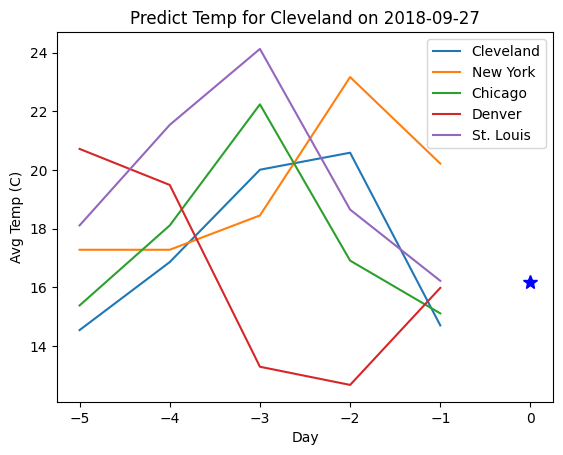

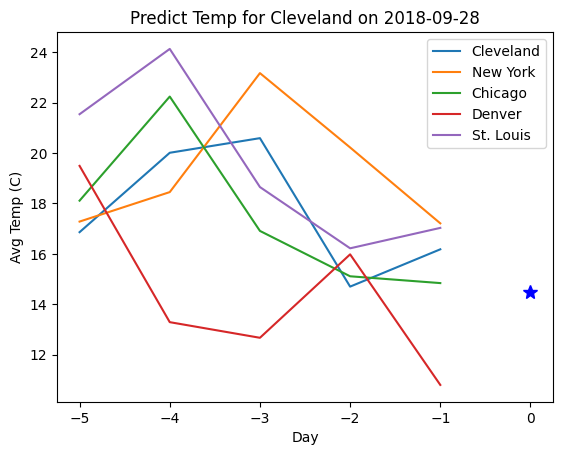

In [59]:
# load data (use xt and yt so that we aren't replacing the MNIST variables)
(xt_train, yt_train, xt_val, yt_val, xt_test, yt_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
''' Data format:
      x_train, y_train: features and target value for each training sample (used to fit model)
      x_val, y_val: features and target value for each validation sample (used to select hyperparameters, such as regularization and K)
      x_test, y_test: features and target value for each test sample (used to evaluate final performance)
      dates_xxx: date of the target value for the corresponding sample
      feature_to_city: maps from a feature number to the city
      feature_to_day: maps from a feature number to a day relative to the target value, e.g. -2 means two days before
      Note: 361 is the temperature of Cleveland on the previous day
'''
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))
baseline_rmse = np.sqrt(np.mean((yt_val[1:]-yt_val[:-1])**2)) # root mean squared error example
print('Baseline - prediction using previous day: RMSE={}'.format(baseline_rmse))

# plot first two x/y for val
plot_temps(xt_val[0], yt_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(xt_val[1], yt_val[1], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])



In [67]:
# K-NN Regression

def regress_KNN(X_trn, y_trn, X_tst, K=1):
  '''
  Predict the target value for each data point in X_tst using a
  K-nearest neighbor regressor based on (X_trn, y_trn), with L2 distance.
  Input: X_trn[i] is the ith training data. y_trn[i] is the ith training label. K is the number of closest neighbors to use.
  Output: return y_pred, where y_pred[i] is the predicted ith test value
  '''
  # TO DO
  knn = KNeighborsRegressor(n_neighbors=K, metric='l2')
  knn.fit(X_trn, y_trn)
  y_pred = knn.predict(X_tst)
  return y_pred

def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  # TO DO
  x2 = x - x[:, fnum][:, np.newaxis]
  y2 = y - x[:, fnum]
  return x2, y2

# KNN with original features
K = 5
y_pred_original = regress_KNN(xt_train, yt_train, xt_test, K)
rmse_original = np.sqrt(mean_squared_error(yt_test, y_pred_original))
print(f"RMSE with original features (K={K}): {rmse_original:.3f}")

# KNN with normalized features
fnum = 361  # previous day temp in Cleveland
xt_train_norm, yt_train_norm = normalize_features(xt_train, yt_train, fnum)
xt_test_norm, yt_test_norm = normalize_features(xt_test, yt_test, fnum)

y_pred_norm = regress_KNN(xt_train_norm, yt_train_norm, xt_test_norm, K)
y_pred_denorm = y_pred_norm + xt_test[:, fnum]
rmse_normalized = np.sqrt(mean_squared_error(yt_test, y_pred_denorm))
print(f"RMSE with normalized features (K={K}): {rmse_normalized:.3f}")

# Validate method with K=3
K_validate = 3
y_pred_validate = regress_KNN(xt_train, yt_train, xt_test, K_validate)
rmse_validate = np.sqrt(mean_squared_error(yt_test, y_pred_validate))
print(f"RMSE with original features (K={K_validate}): {rmse_validate:.3f}")

RMSE with original features (K=5): 3.190
RMSE with normalized features (K=5): 2.900
RMSE with original features (K=3): 3.314


# Part 5

In [72]:
print(x_train.shape)
print(y_train.shape)

(60000, 784)
(10000,)


In [71]:
# Stretch: KNN classification (Select K)
def knn_classify(X_train, y_train, X_test, K):
    knn = KNeighborsClassifier(n_neighbors=K, weights='distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_pred

# Assuming x_train, y_train, x_test, y_test are already loaded

# Split the training data into training and validation sets
X_train = x_train[:10000]
y_train = y_train[:10000]
X_val = x_train[10000:]
y_val = y_train[10000:]

K_values = [1, 3, 5, 11, 25]
val_errors = []

print("Validation Results:")
for K in K_values:
    start_time = time.time()
    y_pred = knn_classify(X_train, y_train, X_val, K)
    error_rate = 1 - accuracy_score(y_val, y_pred)
    val_errors.append(error_rate)
    elapsed_time = time.time() - start_time
    print(f"K={K}: Error rate = {error_rate:.4f}, Time taken = {elapsed_time:.2f} seconds")

best_K = K_values[np.argmin(val_errors)]
print(f"\nBest K value: {best_K}")

# Test with the best K using the full training set
print("\nTesting with the best K using the full training set:")
start_time = time.time()
y_pred_test = knn_classify(x_train, y_train, x_test, best_K)
test_error = 1 - accuracy_score(y_test, y_pred_test)
elapsed_time = time.time() - start_time
print(f"Test Error rate = {test_error:.4f}, Time taken = {elapsed_time:.2f} seconds")

Validation Results:


ValueError: Found input variables with inconsistent numbers of samples: [0, 50000]